# The Deep Learning Homework 3 - Question No. 04 Part A-1
Bahar Mahdavi - SN: 40152521337

## Load and normalize CIFAR10

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1]

batch_size = 32

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
                                          
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:13<00:00, 13063181.35it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Define a Convolutional Neural Network

In [2]:
import torch.nn as nn
import torch.nn.functional as F

model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64), 

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128), 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))

## Define a Loss function and optimizer

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device) # Assuming that we are on a CUDA machine, this should print a CUDA device:

cuda:0


In [4]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## Summarize the architecture of the model,

In [5]:
from torchsummary import summary

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
              ReLU-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
              ReLU-4           [-1, 64, 32, 32]               0
         MaxPool2d-5           [-1, 64, 16, 16]               0
       BatchNorm2d-6           [-1, 64, 16, 16]             128
            Conv2d-7          [-1, 128, 16, 16]          73,856
              ReLU-8          [-1, 128, 16, 16]               0
            Conv2d-9          [-1, 128, 16, 16]         147,584
             ReLU-10          [-1, 128, 16, 16]               0
        MaxPool2d-11            [-1, 128, 8, 8]               0
      BatchNorm2d-12            [-1, 128, 8, 8]             256
           Conv2d-13            [-1, 256, 8, 8]         295,168
             ReLU-14            [-1, 25

In [6]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
count_parameters(model)

5852234

## Train the network (L1-norm with 2e-1 regularization coefficients)

In [8]:
from tqdm import tqdm

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for data in tqdm(trainloader): 
    
    inputs = data[0].to(device, non_blocking=True)
    labels = data[1].to(device, non_blocking=True)
    
    # The following code will be called asynchronously,
    # such that the kernel will be launched and returns control 
    # to the CPU thread before the kernel has actually begun executing
    # has to wait for data to be pushed onto device (synch point)
    
    outputs = model(inputs) # forward
    loss = criterion(outputs, labels)
    
    l2_lambda = 0.01
    l1_norm = sum(abs(p).sum() for p in model.parameters()) # L1 regularization
    loss = loss + l2_lambda * l1_norm

    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backward
    optimizer.step() # optimize

    running_loss += loss.item() # print statistics
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

## Test the network on the test data

In [9]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels = data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
      
      outputs = model(images)

      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss = running_loss/len(testloader)
  accu = 100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [10]:
epochs = 50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 1563/1563 [00:25<00:00, 60.75it/s]


Train Loss: 36.201 | Accuracy: 11.456


100%|██████████| 313/313 [00:03<00:00, 93.97it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 2


100%|██████████| 1563/1563 [00:29<00:00, 52.72it/s]


Train Loss: 6.413 | Accuracy: 9.916


100%|██████████| 313/313 [00:04<00:00, 64.51it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 3


100%|██████████| 1563/1563 [00:26<00:00, 58.17it/s]


Train Loss: 5.710 | Accuracy: 9.870


100%|██████████| 313/313 [00:03<00:00, 95.61it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 4


100%|██████████| 1563/1563 [00:26<00:00, 59.46it/s]


Train Loss: 5.010 | Accuracy: 10.008


100%|██████████| 313/313 [00:03<00:00, 84.12it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 5


100%|██████████| 1563/1563 [00:28<00:00, 54.67it/s]


Train Loss: 4.310 | Accuracy: 9.982


100%|██████████| 313/313 [00:03<00:00, 89.57it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 6


100%|██████████| 1563/1563 [00:26<00:00, 59.15it/s]


Train Loss: 3.610 | Accuracy: 10.064


100%|██████████| 313/313 [00:03<00:00, 92.98it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 7


100%|██████████| 1563/1563 [00:26<00:00, 58.16it/s]


Train Loss: 3.033 | Accuracy: 10.118


100%|██████████| 313/313 [00:04<00:00, 76.85it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 8


100%|██████████| 1563/1563 [00:26<00:00, 59.01it/s]


Train Loss: 2.976 | Accuracy: 9.948


100%|██████████| 313/313 [00:03<00:00, 91.76it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 9


100%|██████████| 1563/1563 [00:26<00:00, 58.47it/s]


Train Loss: 2.976 | Accuracy: 10.110


100%|██████████| 313/313 [00:04<00:00, 68.66it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 10


100%|██████████| 1563/1563 [00:27<00:00, 56.29it/s]


Train Loss: 2.976 | Accuracy: 9.786


100%|██████████| 313/313 [00:03<00:00, 93.35it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 11


100%|██████████| 1563/1563 [00:26<00:00, 58.96it/s]


Train Loss: 2.976 | Accuracy: 9.846


100%|██████████| 313/313 [00:03<00:00, 92.57it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 12


100%|██████████| 1563/1563 [00:26<00:00, 59.83it/s]


Train Loss: 2.976 | Accuracy: 10.070


100%|██████████| 313/313 [00:04<00:00, 69.99it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 13


100%|██████████| 1563/1563 [00:25<00:00, 60.35it/s]


Train Loss: 2.976 | Accuracy: 9.974


100%|██████████| 313/313 [00:03<00:00, 93.47it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 14


100%|██████████| 1563/1563 [00:26<00:00, 60.04it/s]


Train Loss: 2.976 | Accuracy: 10.032


100%|██████████| 313/313 [00:03<00:00, 83.27it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 15


100%|██████████| 1563/1563 [00:26<00:00, 58.49it/s]


Train Loss: 2.976 | Accuracy: 9.914


100%|██████████| 313/313 [00:04<00:00, 71.01it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 16


100%|██████████| 1563/1563 [00:26<00:00, 59.53it/s]


Train Loss: 2.976 | Accuracy: 9.942


100%|██████████| 313/313 [00:03<00:00, 89.54it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 17


100%|██████████| 1563/1563 [00:26<00:00, 59.42it/s]


Train Loss: 2.976 | Accuracy: 10.102


100%|██████████| 313/313 [00:03<00:00, 94.32it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 18


100%|██████████| 1563/1563 [00:26<00:00, 60.09it/s]


Train Loss: 2.976 | Accuracy: 9.812


100%|██████████| 313/313 [00:04<00:00, 71.70it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 19


100%|██████████| 1563/1563 [00:27<00:00, 57.83it/s]


Train Loss: 2.976 | Accuracy: 10.102


100%|██████████| 313/313 [00:03<00:00, 92.94it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 20


100%|██████████| 1563/1563 [00:26<00:00, 59.89it/s]


Train Loss: 2.976 | Accuracy: 9.870


100%|██████████| 313/313 [00:03<00:00, 87.52it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 21


100%|██████████| 1563/1563 [00:26<00:00, 58.86it/s]


Train Loss: 2.976 | Accuracy: 10.152


100%|██████████| 313/313 [00:03<00:00, 83.73it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 22


100%|██████████| 1563/1563 [00:25<00:00, 60.38it/s]


Train Loss: 2.976 | Accuracy: 9.904


100%|██████████| 313/313 [00:03<00:00, 92.62it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 23


100%|██████████| 1563/1563 [00:26<00:00, 59.90it/s]


Train Loss: 2.976 | Accuracy: 10.006


100%|██████████| 313/313 [00:03<00:00, 89.50it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 24


100%|██████████| 1563/1563 [00:27<00:00, 56.58it/s]


Train Loss: 2.976 | Accuracy: 9.954


100%|██████████| 313/313 [00:03<00:00, 90.07it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 25


100%|██████████| 1563/1563 [00:25<00:00, 60.12it/s]


Train Loss: 2.976 | Accuracy: 9.802


100%|██████████| 313/313 [00:03<00:00, 92.88it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 26


100%|██████████| 1563/1563 [00:25<00:00, 60.18it/s]


Train Loss: 2.976 | Accuracy: 10.142


100%|██████████| 313/313 [00:04<00:00, 77.46it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 27


100%|██████████| 1563/1563 [00:26<00:00, 59.44it/s]


Train Loss: 2.976 | Accuracy: 10.036


100%|██████████| 313/313 [00:03<00:00, 91.32it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 28


100%|██████████| 1563/1563 [00:25<00:00, 60.14it/s]


Train Loss: 2.976 | Accuracy: 10.282


100%|██████████| 313/313 [00:03<00:00, 91.73it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 29


100%|██████████| 1563/1563 [00:27<00:00, 57.12it/s]


Train Loss: 2.976 | Accuracy: 9.684


100%|██████████| 313/313 [00:03<00:00, 88.24it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 30


100%|██████████| 1563/1563 [00:28<00:00, 55.50it/s]


Train Loss: 2.976 | Accuracy: 10.084


100%|██████████| 313/313 [00:03<00:00, 83.63it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 31


100%|██████████| 1563/1563 [00:26<00:00, 59.99it/s]


Train Loss: 2.976 | Accuracy: 10.028


100%|██████████| 313/313 [00:03<00:00, 93.06it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 32


100%|██████████| 1563/1563 [00:25<00:00, 60.36it/s]


Train Loss: 2.976 | Accuracy: 10.336


100%|██████████| 313/313 [00:04<00:00, 76.31it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 33


100%|██████████| 1563/1563 [00:26<00:00, 59.68it/s]


Train Loss: 2.976 | Accuracy: 9.812


100%|██████████| 313/313 [00:03<00:00, 89.04it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 34


100%|██████████| 1563/1563 [00:26<00:00, 57.93it/s]


Train Loss: 2.976 | Accuracy: 9.872


100%|██████████| 313/313 [00:03<00:00, 94.85it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 35


100%|██████████| 1563/1563 [00:25<00:00, 60.30it/s]


Train Loss: 2.976 | Accuracy: 9.794


100%|██████████| 313/313 [00:03<00:00, 94.97it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 36


100%|██████████| 1563/1563 [00:25<00:00, 60.26it/s]


Train Loss: 2.976 | Accuracy: 9.904


100%|██████████| 313/313 [00:04<00:00, 71.51it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 37


100%|██████████| 1563/1563 [00:25<00:00, 60.59it/s]


Train Loss: 2.976 | Accuracy: 9.828


100%|██████████| 313/313 [00:03<00:00, 92.36it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 38


100%|██████████| 1563/1563 [00:25<00:00, 60.24it/s]


Train Loss: 2.976 | Accuracy: 9.808


100%|██████████| 313/313 [00:03<00:00, 95.23it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 39


100%|██████████| 1563/1563 [00:27<00:00, 57.73it/s]


Train Loss: 2.976 | Accuracy: 10.214


100%|██████████| 313/313 [00:04<00:00, 73.58it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 40


100%|██████████| 1563/1563 [00:26<00:00, 59.53it/s]


Train Loss: 2.976 | Accuracy: 9.916


100%|██████████| 313/313 [00:03<00:00, 93.03it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 41


100%|██████████| 1563/1563 [00:25<00:00, 60.43it/s]


Train Loss: 2.976 | Accuracy: 9.856


100%|██████████| 313/313 [00:03<00:00, 92.93it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 42


100%|██████████| 1563/1563 [00:26<00:00, 60.06it/s]


Train Loss: 2.976 | Accuracy: 9.768


100%|██████████| 313/313 [00:04<00:00, 73.40it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 43


100%|██████████| 1563/1563 [00:26<00:00, 59.57it/s]


Train Loss: 2.976 | Accuracy: 10.002


100%|██████████| 313/313 [00:04<00:00, 70.95it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 44


100%|██████████| 1563/1563 [00:26<00:00, 59.97it/s]


Train Loss: 2.976 | Accuracy: 10.114


100%|██████████| 313/313 [00:03<00:00, 90.67it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 45


100%|██████████| 1563/1563 [00:26<00:00, 59.59it/s]


Train Loss: 2.976 | Accuracy: 10.050


100%|██████████| 313/313 [00:04<00:00, 70.42it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 46


100%|██████████| 1563/1563 [00:26<00:00, 59.62it/s]


Train Loss: 2.976 | Accuracy: 9.902


100%|██████████| 313/313 [00:03<00:00, 94.40it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 47


100%|██████████| 1563/1563 [00:26<00:00, 59.48it/s]


Train Loss: 2.976 | Accuracy: 10.102


100%|██████████| 313/313 [00:03<00:00, 93.93it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 48


100%|██████████| 1563/1563 [00:27<00:00, 57.15it/s]


Train Loss: 2.976 | Accuracy: 9.916


100%|██████████| 313/313 [00:04<00:00, 76.07it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 49


100%|██████████| 1563/1563 [00:26<00:00, 60.03it/s]


Train Loss: 2.976 | Accuracy: 9.730


100%|██████████| 313/313 [00:03<00:00, 89.98it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 50


100%|██████████| 1563/1563 [00:26<00:00, 59.32it/s]


Train Loss: 2.976 | Accuracy: 9.926


100%|██████████| 313/313 [00:03<00:00, 91.95it/s]

Test Loss: 2.303 | Accuracy: 10.000


## Drowing plots

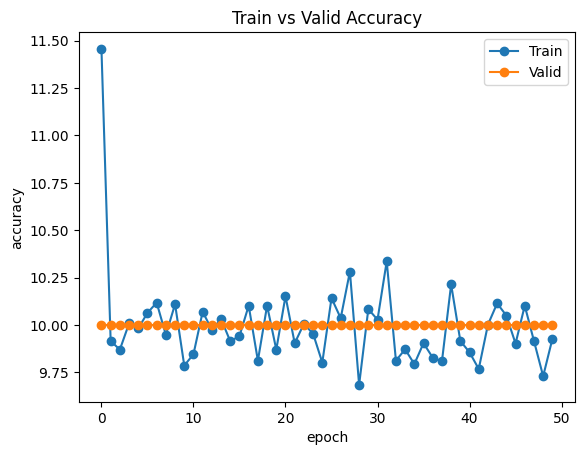

In [11]:
import matplotlib.pyplot as plt 

#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

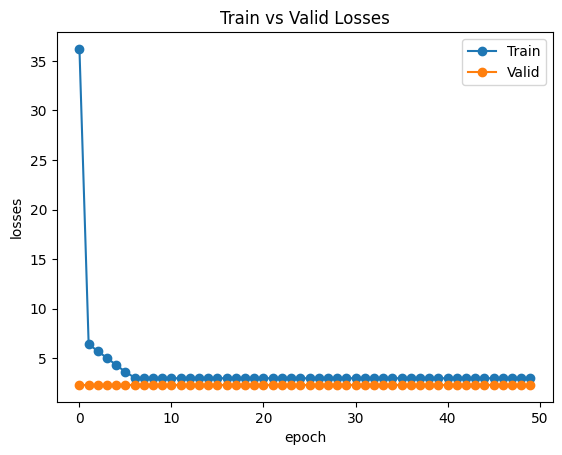

In [12]:
#plot losses
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [13]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:04<00:00, 74.55it/s]


In [14]:
print(y_pred)
print(y_true)

[6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

In [15]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [16]:
import pandas as pd

class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names) # Create pandas dataframe

In [17]:
dataframe

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0,0,0,0,0,0,1000,0,0,0
automobile,0,0,0,0,0,0,1000,0,0,0
bird,0,0,0,0,0,0,1000,0,0,0
cat,0,0,0,0,0,0,1000,0,0,0
deer,0,0,0,0,0,0,1000,0,0,0
dog,0,0,0,0,0,0,1000,0,0,0
frog,0,0,0,0,0,0,1000,0,0,0
horse,0,0,0,0,0,0,1000,0,0,0
ship,0,0,0,0,0,0,1000,0,0,0
truck,0,0,0,0,0,0,1000,0,0,0


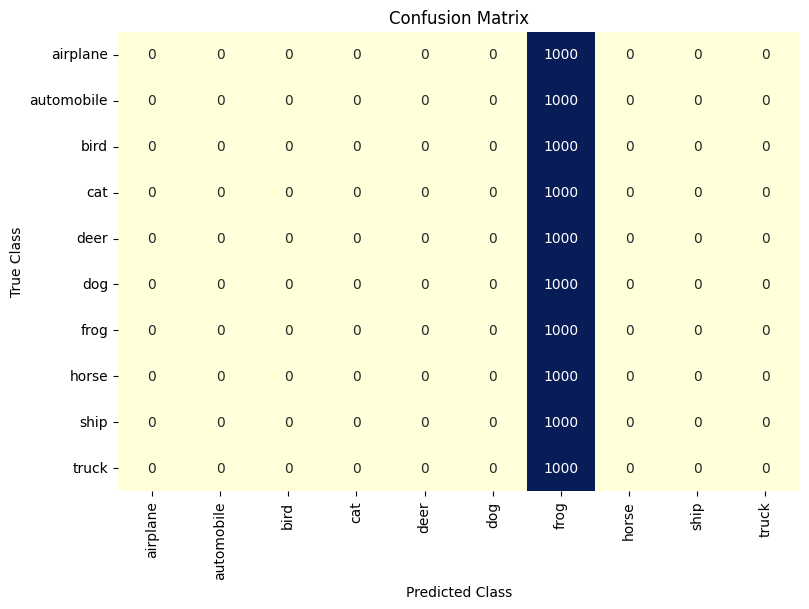

In [18]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d") # Create heatmap

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()

## Train the network (L1-norm with 3e-1 regularization coefficients)

In [19]:
from tqdm import tqdm

train_losses=[]
train_accu=[]

def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss = 0
  correct = 0
  total = 0

  for data in tqdm(trainloader): 
    
    inputs = data[0].to(device, non_blocking=True)
    labels = data[1].to(device, non_blocking=True)
    
    # The following code will be called asynchronously,
    # such that the kernel will be launched and returns control 
    # to the CPU thread before the kernel has actually begun executing
    # has to wait for data to be pushed onto device (synch point)
    
    outputs = model(inputs) # forward
    loss = criterion(outputs, labels)
    
    l2_lambda = 0.001
    l1_norm = sum(abs(p).sum() for p in model.parameters()) # L1 regularization
    loss = loss + l2_lambda * l1_norm

    optimizer.zero_grad() # zero the parameter gradients
    loss.backward() # backward
    optimizer.step() # optimize

    running_loss += loss.item() # print statistics
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  train_loss=running_loss/len(trainloader)
  accu=100.*correct/total
  
  train_accu.append(accu)
  train_losses.append(train_loss)
  print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))

## Test the network on the test data

In [20]:
eval_losses=[]
eval_accu=[]

def test(epoch):
  model.eval()

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    for data in tqdm(testloader):
      images,labels = data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)
      
      outputs = model(images)

      loss = criterion(outputs, labels)
      running_loss += loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  test_loss = running_loss/len(testloader)
  accu = 100.*correct/total

  eval_losses.append(test_loss)
  eval_accu.append(accu)

  print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

In [21]:
epochs = 50
for epoch in range(1,epochs+1): 
  train(epoch)
  test(epoch)


Epoch : 1


100%|██████████| 1563/1563 [00:25<00:00, 60.58it/s]


Train Loss: 2.312 | Accuracy: 9.990


100%|██████████| 313/313 [00:03<00:00, 94.68it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 2


100%|██████████| 1563/1563 [00:25<00:00, 60.16it/s]


Train Loss: 2.310 | Accuracy: 9.810


100%|██████████| 313/313 [00:04<00:00, 75.13it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 3


100%|██████████| 1563/1563 [00:27<00:00, 57.68it/s]


Train Loss: 2.310 | Accuracy: 9.710


100%|██████████| 313/313 [00:03<00:00, 93.54it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 4


100%|██████████| 1563/1563 [00:26<00:00, 59.99it/s]


Train Loss: 2.310 | Accuracy: 9.810


100%|██████████| 313/313 [00:03<00:00, 95.52it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 5


100%|██████████| 1563/1563 [00:25<00:00, 60.13it/s]


Train Loss: 2.310 | Accuracy: 9.826


100%|██████████| 313/313 [00:04<00:00, 77.52it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 6


100%|██████████| 1563/1563 [00:26<00:00, 59.73it/s]


Train Loss: 2.310 | Accuracy: 9.644


100%|██████████| 313/313 [00:03<00:00, 91.45it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 7


100%|██████████| 1563/1563 [00:25<00:00, 61.00it/s]


Train Loss: 2.310 | Accuracy: 9.740


100%|██████████| 313/313 [00:03<00:00, 96.10it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 8


100%|██████████| 1563/1563 [00:27<00:00, 57.81it/s]


Train Loss: 2.310 | Accuracy: 9.744


100%|██████████| 313/313 [00:03<00:00, 96.08it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 9


100%|██████████| 1563/1563 [00:25<00:00, 61.02it/s]


Train Loss: 2.310 | Accuracy: 9.702


100%|██████████| 313/313 [00:04<00:00, 69.74it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 10


100%|██████████| 1563/1563 [00:25<00:00, 60.33it/s]


Train Loss: 2.310 | Accuracy: 9.954


100%|██████████| 313/313 [00:03<00:00, 92.24it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 11


100%|██████████| 1563/1563 [00:29<00:00, 53.77it/s]


Train Loss: 2.310 | Accuracy: 9.746


100%|██████████| 313/313 [00:03<00:00, 91.47it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 12


100%|██████████| 1563/1563 [00:26<00:00, 59.05it/s]


Train Loss: 2.310 | Accuracy: 9.832


100%|██████████| 313/313 [00:05<00:00, 60.65it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 13


100%|██████████| 1563/1563 [00:26<00:00, 59.08it/s]


Train Loss: 2.310 | Accuracy: 9.744


100%|██████████| 313/313 [00:03<00:00, 91.68it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 14


100%|██████████| 1563/1563 [00:27<00:00, 57.18it/s]


Train Loss: 2.310 | Accuracy: 9.786


100%|██████████| 313/313 [00:04<00:00, 70.99it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 15


100%|██████████| 1563/1563 [00:26<00:00, 59.80it/s]


Train Loss: 2.310 | Accuracy: 9.994


100%|██████████| 313/313 [00:03<00:00, 94.14it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 16


100%|██████████| 1563/1563 [00:26<00:00, 59.71it/s]


Train Loss: 2.310 | Accuracy: 9.836


100%|██████████| 313/313 [00:03<00:00, 93.86it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 17


100%|██████████| 1563/1563 [00:27<00:00, 57.45it/s]


Train Loss: 2.310 | Accuracy: 9.780


100%|██████████| 313/313 [00:04<00:00, 75.43it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 18


100%|██████████| 1563/1563 [00:26<00:00, 58.59it/s]


Train Loss: 2.310 | Accuracy: 9.774


100%|██████████| 313/313 [00:03<00:00, 93.75it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 19


100%|██████████| 1563/1563 [00:26<00:00, 58.95it/s]


Train Loss: 2.310 | Accuracy: 9.916


100%|██████████| 313/313 [00:03<00:00, 89.56it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 20


100%|██████████| 1563/1563 [00:27<00:00, 57.61it/s]


Train Loss: 2.310 | Accuracy: 9.808


100%|██████████| 313/313 [00:03<00:00, 85.01it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 21


100%|██████████| 1563/1563 [00:26<00:00, 59.10it/s]


Train Loss: 2.310 | Accuracy: 9.734


100%|██████████| 313/313 [00:03<00:00, 92.31it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 22


100%|██████████| 1563/1563 [00:27<00:00, 56.77it/s]


Train Loss: 2.310 | Accuracy: 10.028


100%|██████████| 313/313 [00:04<00:00, 69.96it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 23


100%|██████████| 1563/1563 [00:26<00:00, 58.56it/s]


Train Loss: 2.310 | Accuracy: 9.864


100%|██████████| 313/313 [00:03<00:00, 92.07it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 24


100%|██████████| 1563/1563 [00:26<00:00, 58.65it/s]


Train Loss: 2.310 | Accuracy: 9.874


100%|██████████| 313/313 [00:03<00:00, 85.82it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 25


100%|██████████| 1563/1563 [00:26<00:00, 57.91it/s]


Train Loss: 2.310 | Accuracy: 9.680


100%|██████████| 313/313 [00:03<00:00, 87.54it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 26


100%|██████████| 1563/1563 [00:26<00:00, 59.96it/s]


Train Loss: 2.310 | Accuracy: 9.720


100%|██████████| 313/313 [00:03<00:00, 92.53it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 27


100%|██████████| 1563/1563 [00:27<00:00, 57.56it/s]


Train Loss: 2.310 | Accuracy: 9.798


100%|██████████| 313/313 [00:03<00:00, 90.49it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 28


100%|██████████| 1563/1563 [00:26<00:00, 58.44it/s]


Train Loss: 2.310 | Accuracy: 9.844


100%|██████████| 313/313 [00:03<00:00, 81.25it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 29


100%|██████████| 1563/1563 [00:26<00:00, 59.88it/s]


Train Loss: 2.310 | Accuracy: 9.714


100%|██████████| 313/313 [00:03<00:00, 95.77it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 30


100%|██████████| 1563/1563 [00:26<00:00, 59.94it/s]


Train Loss: 2.310 | Accuracy: 9.658


100%|██████████| 313/313 [00:03<00:00, 93.46it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 31


100%|██████████| 1563/1563 [00:26<00:00, 59.29it/s]


Train Loss: 2.310 | Accuracy: 9.844


100%|██████████| 313/313 [00:05<00:00, 59.41it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 32


100%|██████████| 1563/1563 [00:25<00:00, 60.45it/s]


Train Loss: 2.310 | Accuracy: 9.536


100%|██████████| 313/313 [00:03<00:00, 94.91it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 33


100%|██████████| 1563/1563 [00:26<00:00, 59.99it/s]


Train Loss: 2.310 | Accuracy: 9.900


100%|██████████| 313/313 [00:03<00:00, 95.88it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 34


100%|██████████| 1563/1563 [00:26<00:00, 59.66it/s]


Train Loss: 2.310 | Accuracy: 9.850


100%|██████████| 313/313 [00:04<00:00, 74.85it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 35


100%|██████████| 1563/1563 [00:25<00:00, 60.42it/s]


Train Loss: 2.310 | Accuracy: 9.860


100%|██████████| 313/313 [00:03<00:00, 96.80it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 36


100%|██████████| 1563/1563 [00:27<00:00, 57.63it/s]


Train Loss: 2.310 | Accuracy: 9.746


100%|██████████| 313/313 [00:03<00:00, 80.52it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 37


100%|██████████| 1563/1563 [00:26<00:00, 59.48it/s]


Train Loss: 2.310 | Accuracy: 9.506


100%|██████████| 313/313 [00:03<00:00, 87.03it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 38


100%|██████████| 1563/1563 [00:26<00:00, 59.91it/s]


Train Loss: 2.310 | Accuracy: 9.704


100%|██████████| 313/313 [00:03<00:00, 96.85it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 39


100%|██████████| 1563/1563 [00:25<00:00, 60.14it/s]


Train Loss: 2.310 | Accuracy: 9.862


100%|██████████| 313/313 [00:03<00:00, 93.03it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 40


100%|██████████| 1563/1563 [00:26<00:00, 58.84it/s]


Train Loss: 2.310 | Accuracy: 9.768


100%|██████████| 313/313 [00:03<00:00, 81.04it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 41


100%|██████████| 1563/1563 [00:26<00:00, 58.21it/s]


Train Loss: 2.310 | Accuracy: 9.754


100%|██████████| 313/313 [00:03<00:00, 98.06it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 42


100%|██████████| 1563/1563 [00:26<00:00, 59.85it/s]


Train Loss: 2.310 | Accuracy: 9.792


100%|██████████| 313/313 [00:04<00:00, 75.43it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 43


100%|██████████| 1563/1563 [00:25<00:00, 60.50it/s]


Train Loss: 2.310 | Accuracy: 9.984


100%|██████████| 313/313 [00:03<00:00, 92.62it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 44


100%|██████████| 1563/1563 [00:26<00:00, 60.07it/s]


Train Loss: 2.310 | Accuracy: 9.900


100%|██████████| 313/313 [00:03<00:00, 93.73it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 45


100%|██████████| 1563/1563 [00:26<00:00, 60.08it/s]


Train Loss: 2.310 | Accuracy: 9.870


100%|██████████| 313/313 [00:03<00:00, 85.22it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 46


100%|██████████| 1563/1563 [00:27<00:00, 56.75it/s]


Train Loss: 2.310 | Accuracy: 9.848


100%|██████████| 313/313 [00:03<00:00, 94.63it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 47


100%|██████████| 1563/1563 [00:26<00:00, 59.79it/s]


Train Loss: 2.310 | Accuracy: 9.866


100%|██████████| 313/313 [00:03<00:00, 97.39it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 48


100%|██████████| 1563/1563 [00:26<00:00, 59.89it/s]


Train Loss: 2.310 | Accuracy: 9.818


100%|██████████| 313/313 [00:04<00:00, 77.30it/s]


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 49


100%|██████████| 1563/1563 [00:26<00:00, 59.57it/s]


Train Loss: 2.310 | Accuracy: 9.978


100%|██████████| 313/313 [00:03<00:00, 90.13it/s] 


Test Loss: 2.303 | Accuracy: 10.000

Epoch : 50


100%|██████████| 1563/1563 [00:26<00:00, 59.79it/s]


Train Loss: 2.310 | Accuracy: 9.928


100%|██████████| 313/313 [00:03<00:00, 95.52it/s]

Test Loss: 2.303 | Accuracy: 10.000


## Drowing plots

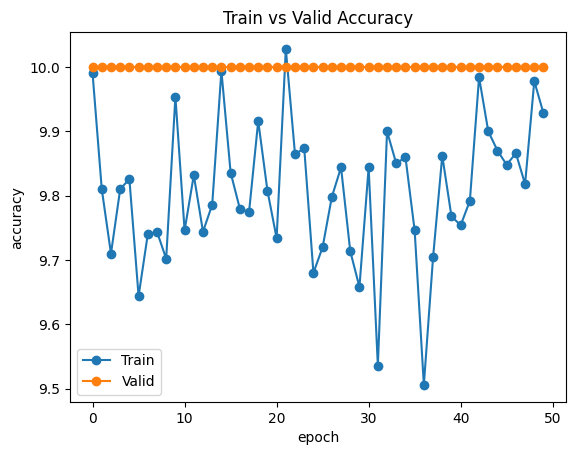

In [22]:
#plot accuracy
plt.plot(train_accu,'-o')
plt.plot(eval_accu,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

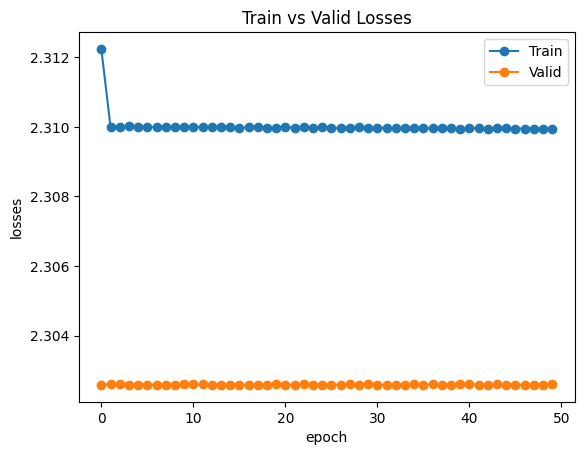

In [23]:
#plot losses
plt.plot(train_losses,'-o')
plt.plot(eval_losses,'-o')
plt.xlabel('epoch')
plt.ylabel('losses')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Losses')

plt.show()

In [24]:
y_true = []
y_pred = []

for data in tqdm(testloader):
  images,labels=data[0].to(device),data[1]  
  y_true.extend(labels.numpy())

  outputs=model(images)

  _, predicted = torch.max(outputs, 1)
  y_pred.extend(predicted.cpu().numpy())

100%|██████████| 313/313 [00:05<00:00, 58.88it/s]


In [25]:
print(y_pred)
print(y_true)

[9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

In [26]:
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)

In [27]:
import pandas as pd

class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataframe = pd.DataFrame(cf_matrix, index=class_names, columns=class_names) # Create pandas dataframe

In [28]:
dataframe

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,0,0,0,0,0,0,0,0,0,1000
automobile,0,0,0,0,0,0,0,0,0,1000
bird,0,0,0,0,0,0,0,0,0,1000
cat,0,0,0,0,0,0,0,0,0,1000
deer,0,0,0,0,0,0,0,0,0,1000
dog,0,0,0,0,0,0,0,0,0,1000
frog,0,0,0,0,0,0,0,0,0,1000
horse,0,0,0,0,0,0,0,0,0,1000
ship,0,0,0,0,0,0,0,0,0,1000
truck,0,0,0,0,0,0,0,0,0,1000


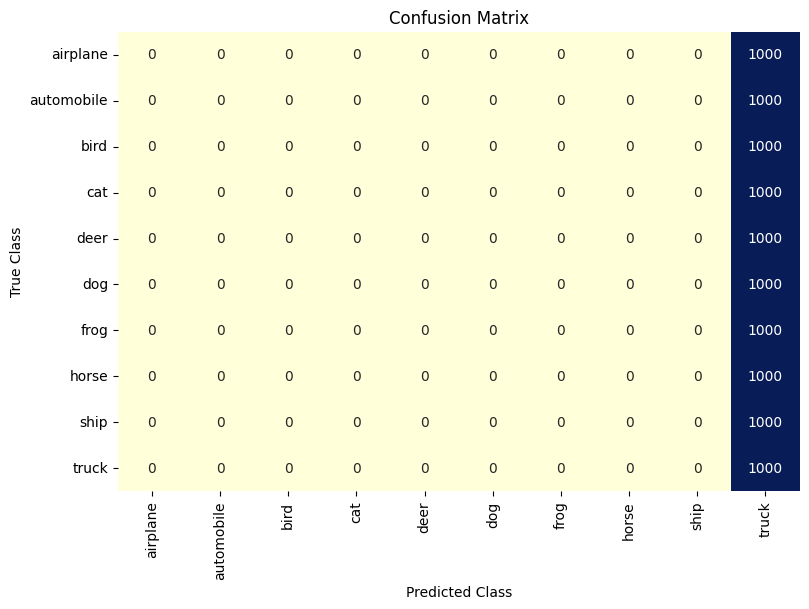

In [29]:
import seaborn as sns

plt.figure(figsize=(8, 6))

sns.heatmap(dataframe, annot=True, cbar=None,cmap="YlGnBu",fmt="d") # Create heatmap

plt.title("Confusion Matrix"), plt.tight_layout()

plt.ylabel("True Class"), 
plt.xlabel("Predicted Class")
plt.show()